# Explaining cortical thickness development: Modelled colocalization trajectories

In [1]:
import os
from os.path import join
import sys

import numpy as np
import pandas as pd
from matplotlib.cm import get_cmap
from matplotlib import pyplot as plt
import seaborn as sns
from skmisc.loess import loess

# custom functions
from scripts.templates import get_destrieux
from scripts.utils import rename_myelin
from scripts.plots_brain import get_parc_gifti, plot_surf_ax

# working path
wd = os.path.dirname(os.path.realpath("__file__"))
print("Working directory:", wd)

# JuSpyce
sys.path.append(os.path.dirname(join(wd, "scripts", "juspyce")))
from juspyce.api import JuSpyce
from juspyce.plots import hide_empty_axes

# centile predictions path
rutherford_dir = join(wd, "data_rutherford")

# predictor data path
predictor_dir = join(wd, "data_predictors")

# plot directory
plot_dir = join(wd, "plots", "colocalization")

Working directory: /Users/llotter/projects/CTdev


## Get data

### Get predictor data

In [2]:
# predictor data
predictors_destrieux = pd.read_csv(join(predictor_dir, 'data_factors_destrieux.csv'), index_col=0)
predictors = list(predictors_destrieux.columns)

# parcellation
parc_destrieux, destrieux_idps = get_destrieux()

### Cortex development data

In [14]:
# GET CT DATA --------------------------------------------------------------------------------------

predicted_ct_f = np.load(join(rutherford_dir, "ct_predicted_f.npy"))
predicted_ct_m = np.load(join(rutherford_dir, "ct_predicted_m.npy"))

parcels_ct = list(np.loadtxt(join(rutherford_dir, "ct_predicted_parcels.txt"), str))
cent_ct = list(np.loadtxt(join(rutherford_dir, "ct_predicted_centiles.txt")))
tp_ct = list(np.loadtxt(join(rutherford_dir, "ct_predicted_tps.txt")))

# collect ct data in 2d dataframes for each centile restricted to relevant age range
predicted_ct_f_dict, predicted_ct_m_dict = dict(), dict()

# iterate centiles
for i, c in enumerate(cent_ct):
    predicted_ct_f_dict[c] = pd.DataFrame(
        data=predicted_ct_f[:,:,i].T, 
        index=tp_ct, 
        columns=parcels_ct
    )\
        .loc[np.arange(5,90.1,0.5),:]
    predicted_ct_m_dict[c] = pd.DataFrame(
        data=predicted_ct_m[:,:,i].T, 
        index=tp_ct, 
        columns=parcels_ct
    )\
        .loc[np.arange(5,90.1,0.5),:]
        
# reshape using 2d index
predicted_ct_f_df = pd.concat(predicted_ct_f_dict, axis=0, names=["cent", "tp"]) 
predicted_ct_m_df = pd.concat(predicted_ct_m_dict, axis=0, names=["cent", "tp"]) 

# average between females and males
predicted_ct_fm_df = (predicted_ct_f_df + predicted_ct_m_df) / 2
    
# dimensions
n_tp_ct, n_parcels_ct = predicted_ct_f_dict[0.5].shape

# check --------------------------------------------------------------------------------------------

print(f"Shape predictors_destrieux: parcels x atlases {predictors_destrieux.shape}")

print(f"Shape predicted_ct: parcels x timepoints x centiles {predicted_ct_f.shape}")
print(f"Shape predicted_ct_f_dict: timepoints x parcels {predicted_ct_f_dict[0.5].shape}")
print(f"Shape predicted_ct_fm_df: (centiles x timepoints) x parcels {predicted_ct_fm_df.shape}")

# source data --------------------------------------------------------------------------------------
# save as multi-indexed 2d df
pd.concat(
    {
        "female": predicted_ct_f_df,
        "male": predicted_ct_m_df,
        "sex_average": predicted_ct_fm_df
    },
    names=["sex"]
).astype(np.float16).to_csv(join(wd, "data_rutherford", "ct_predicted_df_assource.csv"))

Shape predictors_destrieux: parcels x atlases (148, 21)
Shape predicted_ct: parcels x timepoints x centiles (148, 230, 7)
Shape predicted_ct_f_dict: timepoints x parcels (171, 148)
Shape predicted_ct_fm_df: (centiles x timepoints) x parcels (1197, 148)


## Development of cortex - predictor correlations

In [4]:
# initialize & import data
juspyce_spearman = dict()
for sex, target in zip(["f", "m", "fm"],
                       [predicted_ct_f_df, predicted_ct_m_df, predicted_ct_fm_df]):
            
    # initialize juspyce
    juspyce_spearman[sex] = JuSpyce(
        x=predictors_destrieux.T,
        y=target,
        data_space="fsaverage",
        parcellation=parc_destrieux,
        parcellation_space="fsaverage",
        parcellation_density="10k",
        standardize=False,
        drop_nan=False,
        n_proc=-1
    ).fit()
    # correlate
    juspyce_spearman[sex].predict(method="spearman", r_to_z=True)
    # save data as juSpyce object
    juspyce_spearman[sex].to_pickle(join(wd, "data_rutherford", f"juspyce_ct_spearman_{sex}.pkl.gz"))

INFO: Checking input data for x (should be, e.g., PET data):
INFO: Input type: DataFrame, assuming parcellated data with shape (n_files/subjects/etc, n_parcels).
INFO: Got 'x' data for 21 x 148 parcels.
INFO: Checking input data for y (should be, e.g., subject data):
INFO: Input type: DataFrame, assuming parcellated data with shape (n_files/subjects/etc, n_parcels).
INFO: Got 'y' data for 1197 x 148 parcels.


Predicting (spearman, -1 proc):   0%|          | 0/1197 [00:00<?, ?it/s]

INFO: Creating deep copy of JuSpyce object.
INFO: Saved complete gzip compressed object to /Users/llotter/projects/CTdev/data_rutherford/juspyce_ct_spearman_f.pkl.gz.
INFO: Checking input data for x (should be, e.g., PET data):
INFO: Input type: DataFrame, assuming parcellated data with shape (n_files/subjects/etc, n_parcels).
INFO: Got 'x' data for 21 x 148 parcels.
INFO: Checking input data for y (should be, e.g., subject data):
INFO: Input type: DataFrame, assuming parcellated data with shape (n_files/subjects/etc, n_parcels).
INFO: Got 'y' data for 1197 x 148 parcels.


Predicting (spearman, -1 proc):   0%|          | 0/1197 [00:00<?, ?it/s]

INFO: Creating deep copy of JuSpyce object.
INFO: Saved complete gzip compressed object to /Users/llotter/projects/CTdev/data_rutherford/juspyce_ct_spearman_m.pkl.gz.
INFO: Checking input data for x (should be, e.g., PET data):
INFO: Input type: DataFrame, assuming parcellated data with shape (n_files/subjects/etc, n_parcels).
INFO: Got 'x' data for 21 x 148 parcels.
INFO: Checking input data for y (should be, e.g., subject data):
INFO: Input type: DataFrame, assuming parcellated data with shape (n_files/subjects/etc, n_parcels).
INFO: Got 'y' data for 1197 x 148 parcels.


Predicting (spearman, -1 proc):   0%|          | 0/1197 [00:00<?, ?it/s]

INFO: Creating deep copy of JuSpyce object.
INFO: Saved complete gzip compressed object to /Users/llotter/projects/CTdev/data_rutherford/juspyce_ct_spearman_fm.pkl.gz.


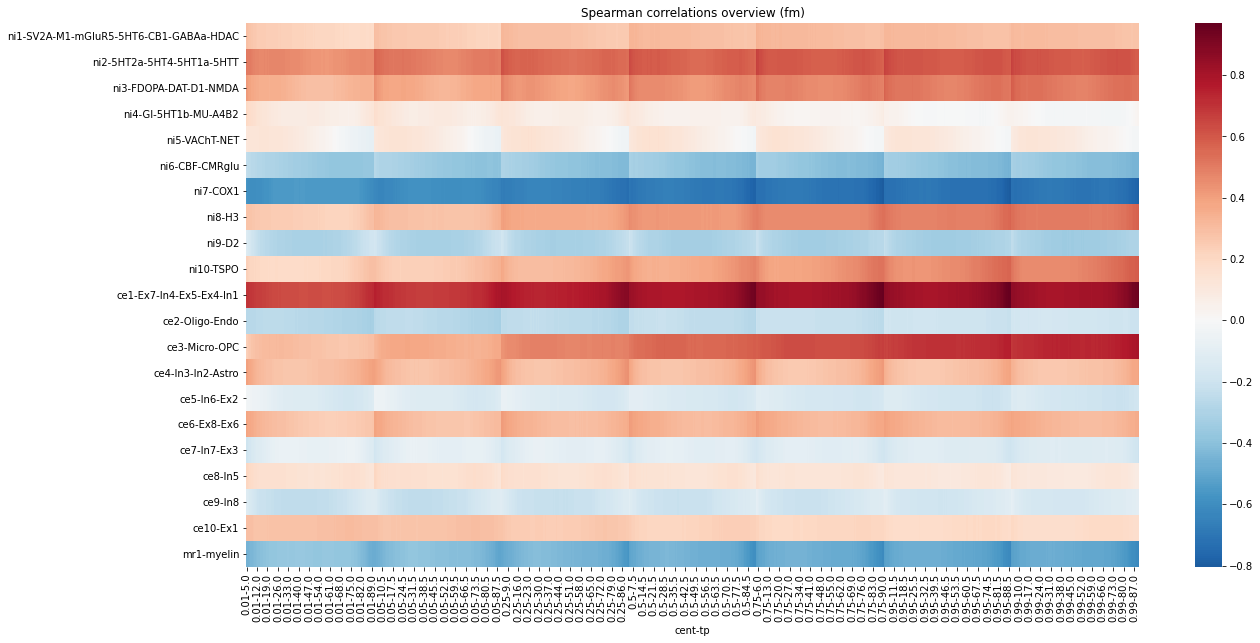

In [5]:
# sanity check: show as heatmap
fig, ax = plt.subplots(1, figsize=(20,10))
sns.heatmap(juspyce_spearman["fm"].predictions["spearman"].T, center=0, cmap="RdBu_r", ax=ax)
_ = ax.set_title(f"Spearman correlations overview (fm)")

## Plot

### Development of CT correlations

In [6]:
# If this is rerun and single-subject data is not available (i.e., if you downloaded this file from 
# GitHub), you will have to set 'plot_scatter' to False.
plot_lines = True

/var/folders/6n/h4150p8d5gz5kbnqv5_406940000gp/T/ipykernel_1337/4067124493.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = np.r_[get_cmap("tab10")(range(len([p for p in predictors if p.startswith("ni")]))),
/var/folders/6n/h4150p8d5gz5kbnqv5_406940000gp/T/ipykernel_1337/4067124493.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  get_cmap("tab10")(range(len([p for p in predictors if p.startswith("ce")]))),
/var/folders/6n/h4150p8d5gz5kbnqv5_406940000gp/T/ipykernel_1337/4067124493.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotl

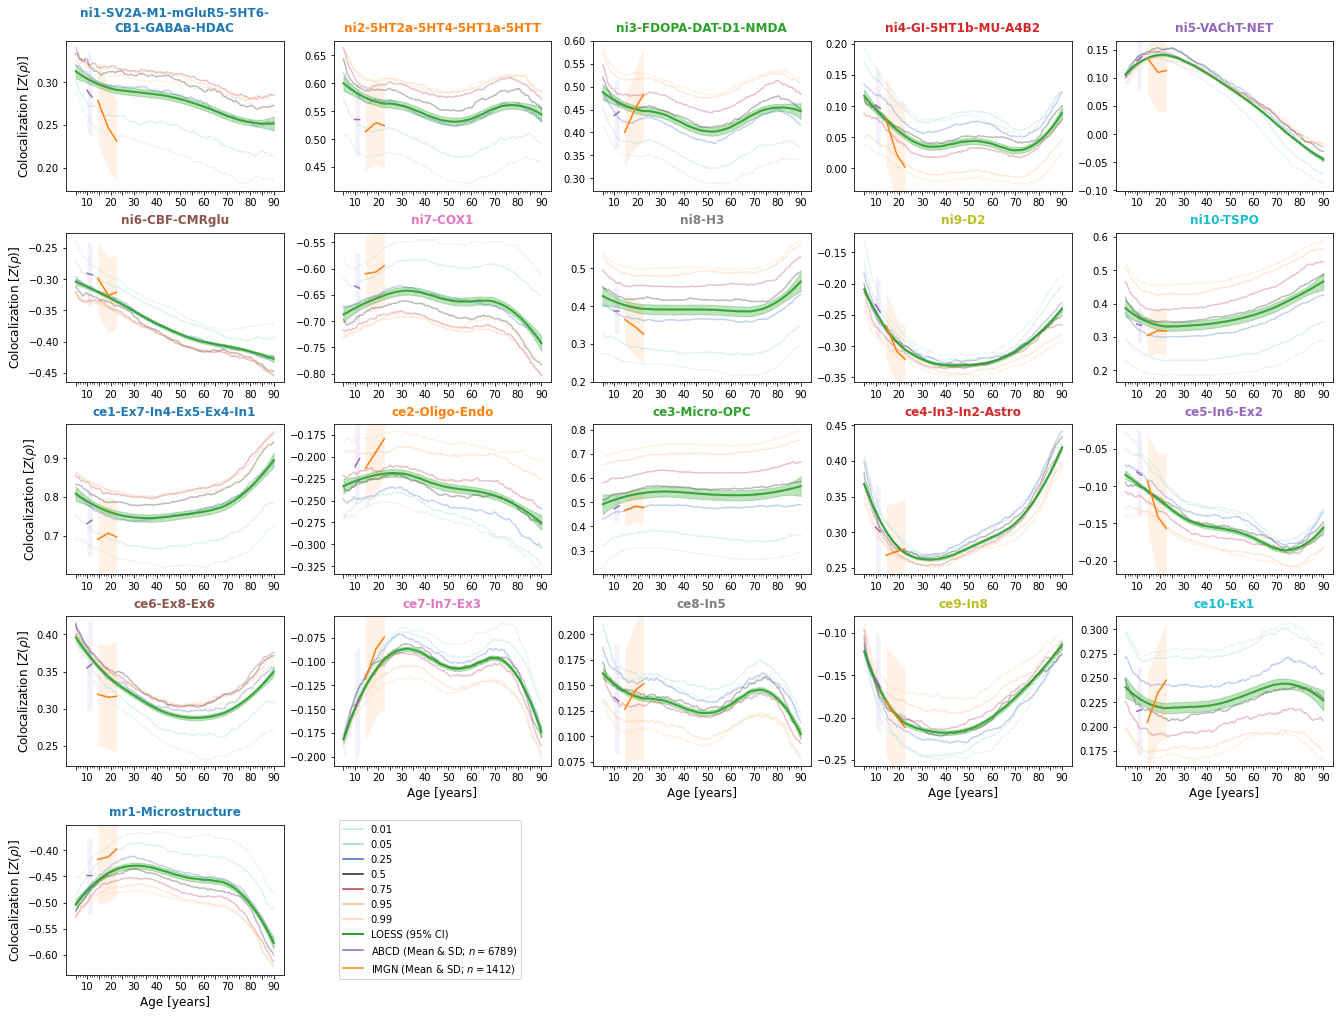

/var/folders/6n/h4150p8d5gz5kbnqv5_406940000gp/T/ipykernel_1337/4067124493.py:157: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:


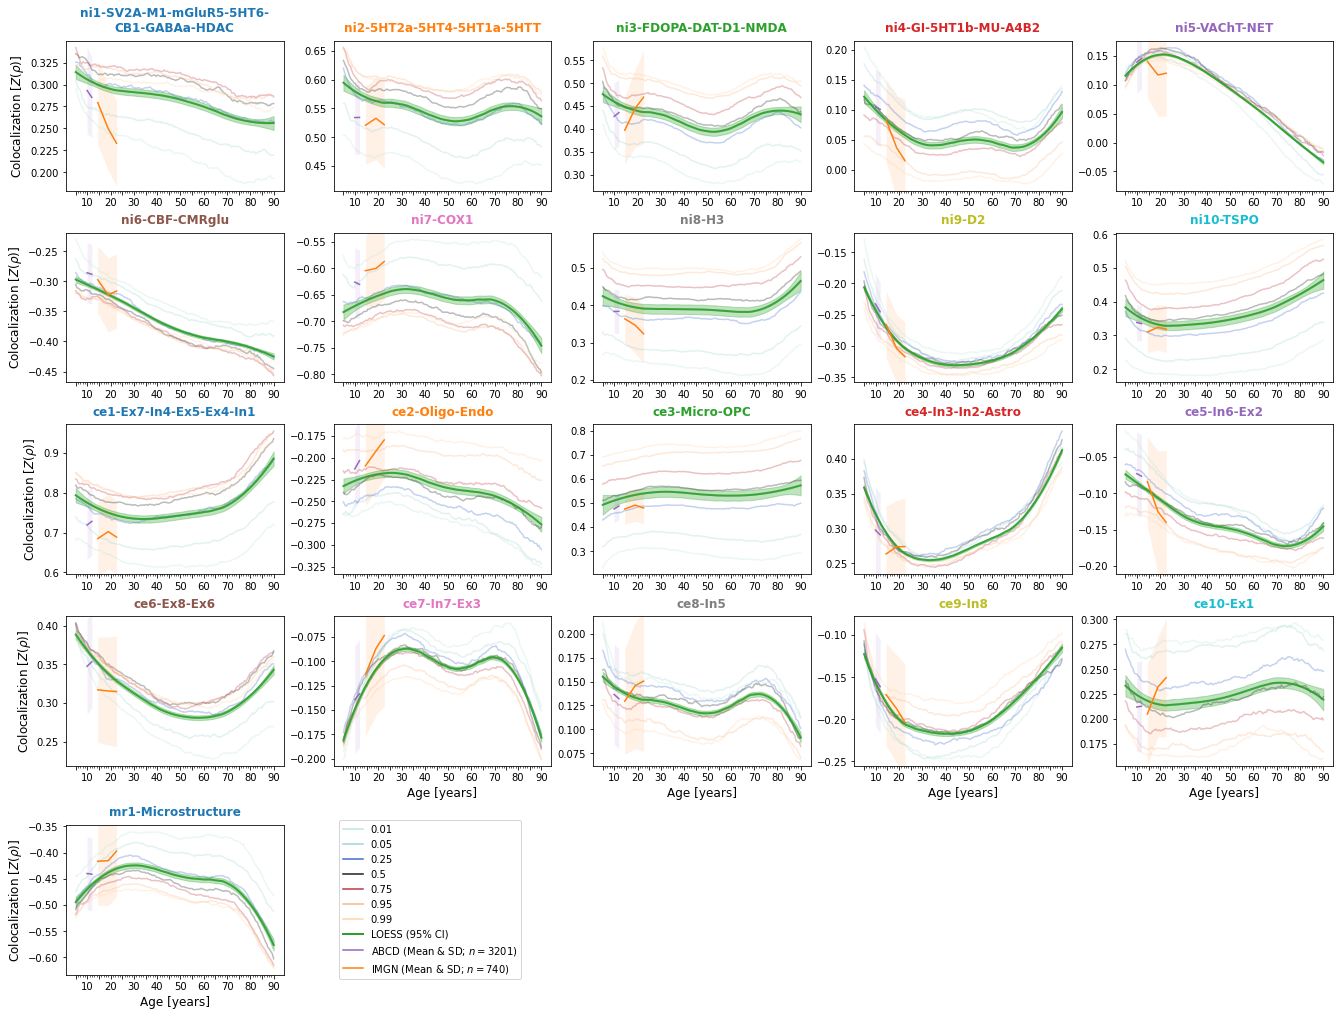

/var/folders/6n/h4150p8d5gz5kbnqv5_406940000gp/T/ipykernel_1337/4067124493.py:157: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:


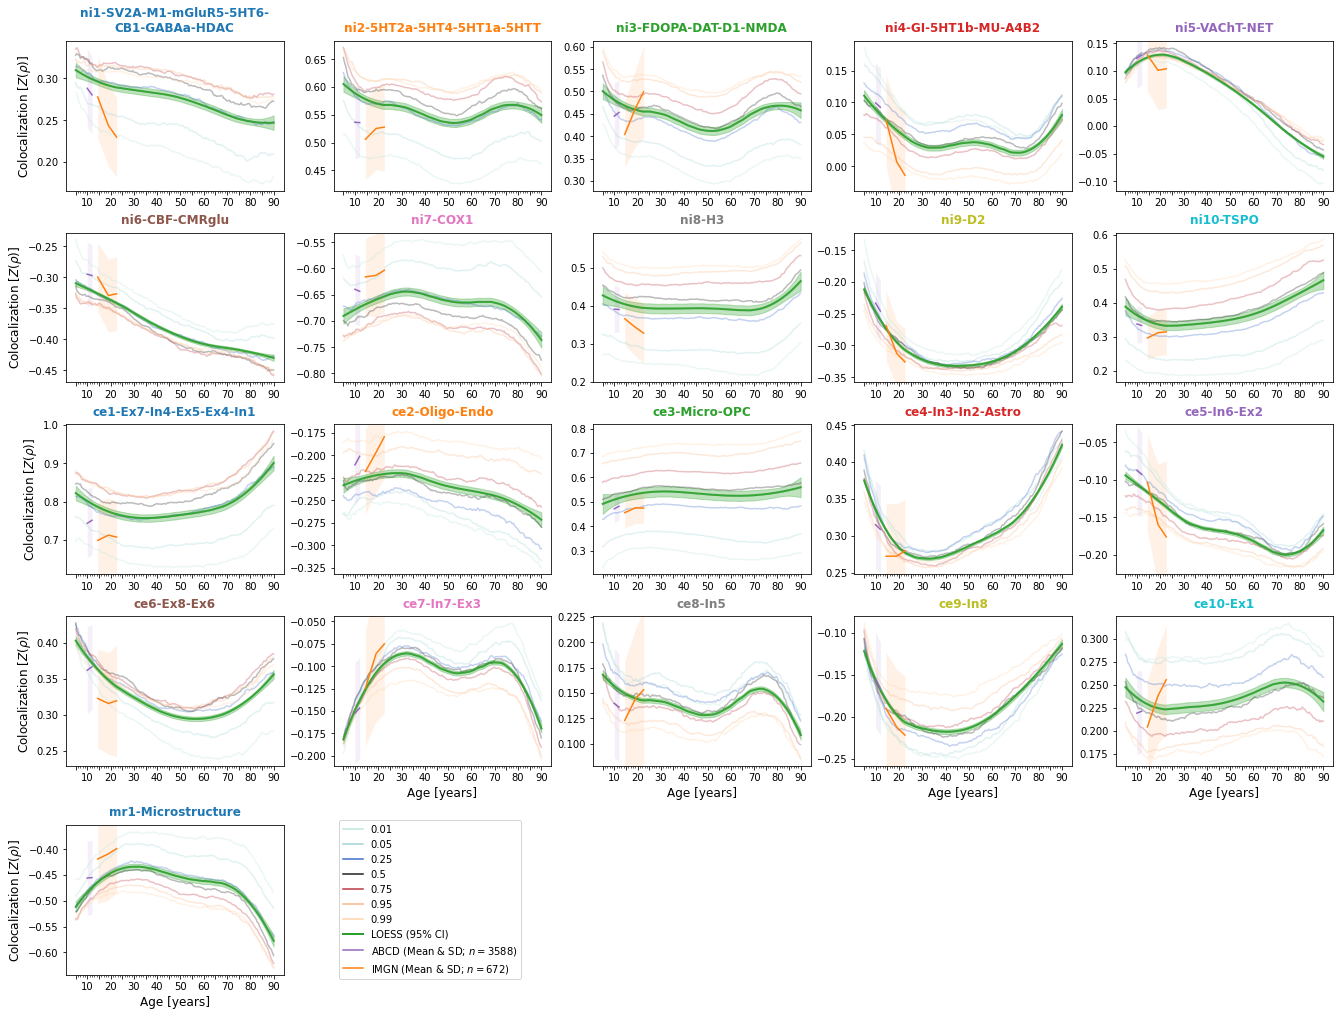

In [29]:
from matplotlib.collections import LineCollection
from scripts.utils import na

if plot_lines:
    # single subject data
    res_cross = pd.read_feather(join(wd, "data_ABCD-IMGN", "res_cross.ftr")) \
        .set_index(["ds", "id", "tp", "analysis"]).sort_index()
    imgn = pd.read_feather(join(wd, "data_ABCD-IMGN", "imgn.ftr")) \
        .set_index(["id", "tp"], drop=False).sort_index()
    abcd = pd.read_feather(join(wd, "data_ABCD-IMGN", "abcd.ftr")) \
        .set_index(["id", "tp"], drop=False).sort_index()

cent_plot = [0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]
n_cols = 5
n_rows = int(np.ceil(len(predictors)/n_cols))
predictors_tmp = predictors[:4] + [""] + predictors[4:7] + ["mr1-myelin", ""] + predictors[7:-1]
colors = np.r_[get_cmap("tab10")(range(len([p for p in predictors if p.startswith("ni")]))),
               get_cmap("tab10")(range(len([p for p in predictors if p.startswith("ce")]))),
               get_cmap("tab10")(range(1))]

# iterate sexes (+ sex-average)
for sex in ["fm", "f", "m"]:
        
    # figure
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(3.7*n_cols, 2.8*n_rows), constrained_layout=True)
    axes = axes.ravel()
    
    # colocalization data
    df = juspyce_spearman[sex].predictions["spearman"]

    # array to store loess data
    spearman_loess = {
        "loess": np.zeros((n_tp_ct, len(predictors))),
        "ci_up": np.zeros((n_tp_ct, len(predictors))),
        "ci_low": np.zeros((n_tp_ct, len(predictors)))
    }
    
    # source data
    source_data = {}

    # iterate predictors
    i_pred = 0
    for i_ax, pred in enumerate(predictors):
        ax = axes[i_ax]
                
        # get data in reshaped form
        y_reshape = df.loc[[i for i in df.index if i[0] in cent_plot], pred]\
            .sort_index(level="tp")
        x_reshape = np.array(y_reshape.index.get_level_values("tp"))
        cent_reshape = np.array(y_reshape.index.get_level_values("cent"))
        y_reshape = y_reshape.values
        l = loess(x=x_reshape, y=y_reshape, degree=2, span=1/2)
        l.fit()
        l_pred = l.predict(x_reshape, stderror=True)
        l_conf = l_pred.confidence()
        y_smooth = l_pred.values
        y_ci_up = l_conf.upper
        y_ci_low = l_conf.lower
        
        # store data
        spearman_loess["loess"][:, i_pred] = y_smooth.reshape((n_tp_ct, len(cent_plot)))[:,0]
        spearman_loess["ci_up"][:, i_pred] = y_ci_up.reshape((n_tp_ct, len(cent_plot)))[:,0]
        spearman_loess["ci_low"][:, i_pred] = y_ci_low.reshape((n_tp_ct, len(cent_plot)))[:,0]

        # PLOT
        ax.set_title(rename_myelin(pred) if len(pred)<30 else pred[:24]+"\n"+pred[24:], 
                     c=colors[i_pred], weight="semibold", size=12, va="bottom")   
        # plot percentile lines
        sns.lineplot(x=x_reshape, y=y_reshape, hue=cent_reshape, palette="icefire", 
                     alpha=0.3, ax=ax, legend="full")
        # plot loess lines
        sns.lineplot(x=x_reshape, y=y_smooth, color="tab:green", alpha=0.9, linewidth=2, 
                     ax=ax, legend="brief", label="LOESS (95% CI)")
        # plot CI
        ax.fill_between(x_reshape, y_ci_up, y_ci_low, alpha=0.3, color="tab:green")
        
        if plot_lines:
        
            # get current y limits
            y_lims = ax.get_ylim()
            
            # plot subjects
            for df_single, ds, c in zip(
                [abcd, imgn],
                ["abcd", "imgn"],
                ["tab:purple", "tab:orange"]):
                
                # Sex-specific single subject data
                subs = res_cross.loc[(ds, na(), na(), "harm")].index.get_level_values("id").unique().tolist()
                if sex != "fm":
                    subs = [sub for sub in subs if sub in df_single.loc[df_single.sex_str==sex.upper(), "id"]]

                # data
                temp = res_cross \
                    .loc[(ds, subs, na(), "rescaled")].droplevel(["ds", "analysis"]) \
                    .merge(df_single.age, left_index=True, right_index=True, how="left") \
                    .loc[:, ["age", pred]]
                
                # plot
                ax.add_collection(
                    LineCollection(
                        [temp.loc[sub] for sub in temp.index.get_level_values("id")],
                        alpha=0.02 if ds=="imgn" else 0.01,
                        color=c,
                        lw=0.05
                    )
                )
                ax.plot(
                    *[temp.groupby("tp").mean()[c] for c in ["age", pred]], 
                    c=c,
                    label=f"{ds.upper()} (Mean & SD; $n={len(subs)}$)",
                )
                ax.fill_between(
                    temp.groupby("tp").mean()["age"],
                    y1=temp.groupby("tp").mean()[pred] - temp.groupby("tp").std()[pred],
                    y2=temp.groupby("tp").mean()[pred] + temp.groupby("tp").std()[pred],
                    color=c,
                    alpha=0.1,
                    lw=0,
                )
                
            # set old y limits (will cut away some (nearly invisible) subject dots)
            ax.set_ylim(y_lims)
                
        # remove legend 
        ax.legend().set_visible(False)
        # x axis
        ax.set_xticks(np.arange(5,91,5))
        ax.set_xticks(np.arange(5,91,1), minor=True)
        ax.set_xticklabels(sum([["",i] for i in np.arange(10,91,10)], []))
       
        # save source data
        source_data[pred] = pd.DataFrame(
            {
                f"centile_{c:.02f}": df.loc[(c, slice(None)), pred].values for c in cent_plot
            } | {
                "loess": spearman_loess["loess"][:, i_pred],
                "loess_ci_up": spearman_loess["ci_up"][:, i_pred],
                "loess_ci_low": spearman_loess["ci_low"][:, i_pred]
            },
            index=pd.Index(np.arange(5, 90.5, 0.5), name="tp")
        )
         
        # index
        i_pred += 1
        
    # empty plots   
    hide_empty_axes(axes)
            
    # legend
    handles, labels = axes[0].get_legend_handles_labels()
    leg = axes[i_ax+1].legend(
        *axes[0].get_legend_handles_labels(), 
        loc='center left', 
        ncol=1, #bbox_to_anchor=(0.41, 0.17))  #(0.94, 0.85))
    )
    for lh in leg.legendHandles: 
        lh.set_alpha(1)
    
    # layout
    [axes[i].set_xlabel("Age [years]", size=12) for i in range(16, 21)]
    [axes[i*n_cols].set_ylabel("Colocalization "+r"[$Z (\rho)$]", size=12) for i in range(n_rows)]
    
    # save
    fig.savefig(join(plot_dir, f"dev_ct_spearman_{sex}.png"), bbox_inches="tight", dpi=300)
    plt.show()
    plt.close()
    
    # loess data
    pd.concat(
        [pd.DataFrame(spearman_loess[k], columns=predictors) \
            .assign(metric=k, tp=np.arange(5, 90.5, 0.5), ) \
            .set_index(["tp", "metric"]) \
            for k in spearman_loess]
    ).sort_index().to_csv(join(wd, "data_rutherford", f"dev_ct_spearman_loess_{sex}.csv"))
    
    # source data
    pd.concat(source_data, names=["marker", "timepoint"]) \
        .to_csv(join(plot_dir, f"dev_ct_spearman_{sex}_source.csv"))

### Age differences

In [21]:
loess_pred_f = pd.read_csv(join(wd, "data_rutherford", f"dev_ct_spearman_loess_f.csv"), index_col=[0,1])
loess_pred_m = pd.read_csv(join(wd, "data_rutherford", f"dev_ct_spearman_loess_m.csv"), index_col=[0,1])

/var/folders/6n/h4150p8d5gz5kbnqv5_406940000gp/T/ipykernel_1429/1562410976.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  get_cmap("tab10")(range(len([p for p in predictors if p.startswith("ni")]))),
/var/folders/6n/h4150p8d5gz5kbnqv5_406940000gp/T/ipykernel_1429/1562410976.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  get_cmap("tab10")(range(len([p for p in predictors if p.startswith("ce")]))),
/var/folders/6n/h4150p8d5gz5kbnqv5_406940000gp/T/ipykernel_1429/1562410976.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]

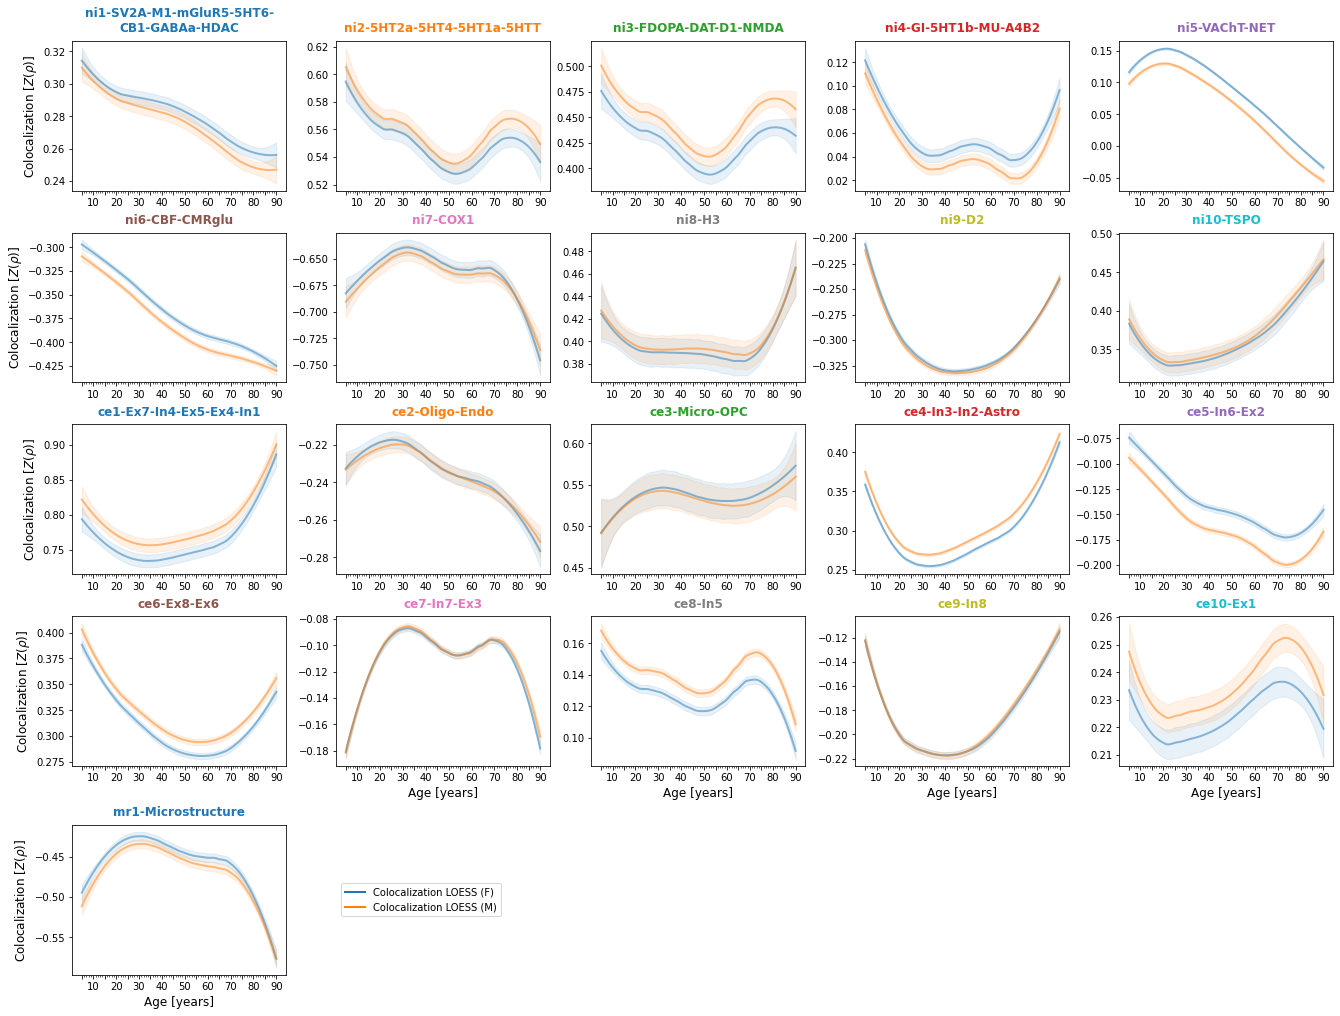

In [27]:
n_cols = 5
n_rows = int(np.ceil(len(predictors)/n_cols))

colors_pred = np.r_[
    get_cmap("tab10")(range(len([p for p in predictors if p.startswith("ni")]))),
    get_cmap("tab10")(range(len([p for p in predictors if p.startswith("ce")]))),
    get_cmap("tab10")(range(1))
]
        
# figure
fig, axes = plt.subplots(n_rows, n_cols, figsize=(3.7*n_cols, 2.8*n_rows), constrained_layout=True,
                         sharex=False, sharey=False)
axes = axes.ravel()

# iterate preds
for i, pred in enumerate(predictors):
    
    ax =  axes[i]
    
    ax.set_title(rename_myelin(pred) if len(pred)<30 else pred[:24]+"\n"+pred[24:], 
                 c=colors_pred[i], weight="semibold", size=12, va="bottom")   

    for sex, loess_pred in [("f", loess_pred_f), ("m", loess_pred_m)]:
        ax.fill_between(
            loess_pred.loc[(slice(None), "loess"), :].index.get_level_values("tp"),
            loess_pred.loc[(slice(None), "ci_up"), pred],
            loess_pred.loc[(slice(None), "ci_low"), pred],
            color="tab:blue" if sex=="f" else "tab:orange",
            alpha=0.1,
            zorder=-10
        )
        ax.plot(
            loess_pred.loc[(slice(None), "loess"), :].index.get_level_values("tp"),
            loess_pred.loc[(slice(None), "loess"), pred],
            c="tab:blue" if sex=="f" else "tab:orange",
            lw=2,
            alpha=0.5,
            zorder=-9,
            label=f"Colocalization LOESS ({sex.upper()})"
        )
    
    ax.set_xticks(np.arange(5,91,5))
    ax.set_xticks(np.arange(5,91,1), minor=True)
    ax.set_xticklabels(sum([["",i] for i in np.arange(10,91,10)], []))
        
# empty plots   
[axes[i].set_axis_off() for i in range(len(predictors), len(axes))]
        
# legend
handles, labels = ax.get_legend_handles_labels()
leg = axes[i+1].legend(handles=handles, labels=labels, loc='center left',)
for lh in leg.legendHandles: 
    lh.set_alpha(1)

# layout
[axes[i].set_xlabel("Age [years]", size=12) for i in range(16, 21)]
[axes[i*n_cols].set_ylabel("Colocalization "+r"$[Z(\rho)]$", size=12) for i in range(n_rows)]
    
fig.savefig(join(plot_dir, "dev_ct_spearman_sex_comp.pdf"), bbox_inches="tight")

### Rate of change in correlations

In [30]:
# load loess prediction for averaged male/female data
loess_pred = pd.read_csv(join(wd, "data_rutherford", f"dev_ct_spearman_loess_fm.csv"), index_col=[0,1])
display(loess_pred.head(5))

ni1-SV2A-M1-mGluR5-5HT6-CB1-GABAa-HDAC  ni2-5HT2a-5HT4-5HT1a-5HTT  \
tp  metric                                                                      
5.0 ci_low                                0.304443                   0.586455   
    ci_up                                 0.320872                   0.614276   
    loess                                 0.312657                   0.600366   
5.5 ci_low                                0.303957                   0.585504   
    ci_up                                 0.319452                   0.611745   

            ni3-FDOPA-DAT-D1-NMDA  ni4-GI-5HT1b-MU-A4B2  ni5-VAChT-NET  \
tp  metric                                                               
5.0 ci_low               0.470810              0.106740       0.102363   
    ci_up                0.505448              0.126548       0.110077   
    loess                0.488129              0.116644       0.106220   
5.5 ci_low               0.469852              0.104963       0.104725   
    ci_up                0.502523              0.123646       0.112001   

            ni6-CBF-CMRglu  ni7-COX1    ni8-H3    ni9-D2  ni10-TSPO  ...  \
tp  metric                                                           ...   
5.0 ci_low       -0.309123 -0.702062  0.401862 -0.213903   0.360427  ...   
    ci_up        -0.298818 -0.672509  0.451699 -0.204248   0.412060  ...   
    loess        -0.303970 -0.687286  0.426781 -0.209076   0.386244  ...   
5.5 ci_low       -0.309651 -0.699927  0.401681 -0.217615   0.359080  ...   
    ci_up        -0.299931 -0.672052  0.448687 -0.208508   0.407780  ...   

            ce2-Oligo-Endo  ce3-Micro-OPC  ce4-In3-In2-Astro  ce5-In6-Ex2  \
tp  metric                                                                  
5.0 ci_low       -0.242131       0.450471           0.364171    -0.090084   
    ci_up        -0.225006       0.532942           0.370934    -0.078794   
    loess        -0.233569       0.491707           0.367553    -0.084439   
5.5 ci_low       -0.241003       0.454795           0.360037    -0.090910   
    ci_up        -0.224851       0.532582           0.366416    -0.080261   

            ce6-Ex8-Ex6  ce7-In7-Ex3   ce8-In5   ce9-In8  ce10-Ex1  mr1-myelin  
tp  metric                                                                      
5.0 ci_low     0.390260    -0.186042  0.156676 -0.127460  0.230042   -0.514741  
    ci_up      0.402462    -0.176910  0.166839 -0.116562  0.251225   -0.493147  
    loess      0.396361    -0.181476  0.161757 -0.122011  0.240634   -0.503944  
5.5 ci_low     0.388268    -0.182243  0.155770 -0.130964  0.229500   -0.511171  
    ci_up      0.399778    -0.173629  0.165356 -0.120685  0.249480   -0.490804  

[5 rows x 21 columns]

#### Plot coloc. trajectories, change rates, and brains

/var/folders/6n/h4150p8d5gz5kbnqv5_406940000gp/T/ipykernel_1337/1862244985.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = np.r_[get_cmap("tab10")(range(len([p for p in predictors if p.startswith("ni")]))),
/var/folders/6n/h4150p8d5gz5kbnqv5_406940000gp/T/ipykernel_1337/1862244985.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  get_cmap("tab10")(range(len([p for p in predictors if p.startswith("ce")]))),
/var/folders/6n/h4150p8d5gz5kbnqv5_406940000gp/T/ipykernel_1337/1862244985.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.

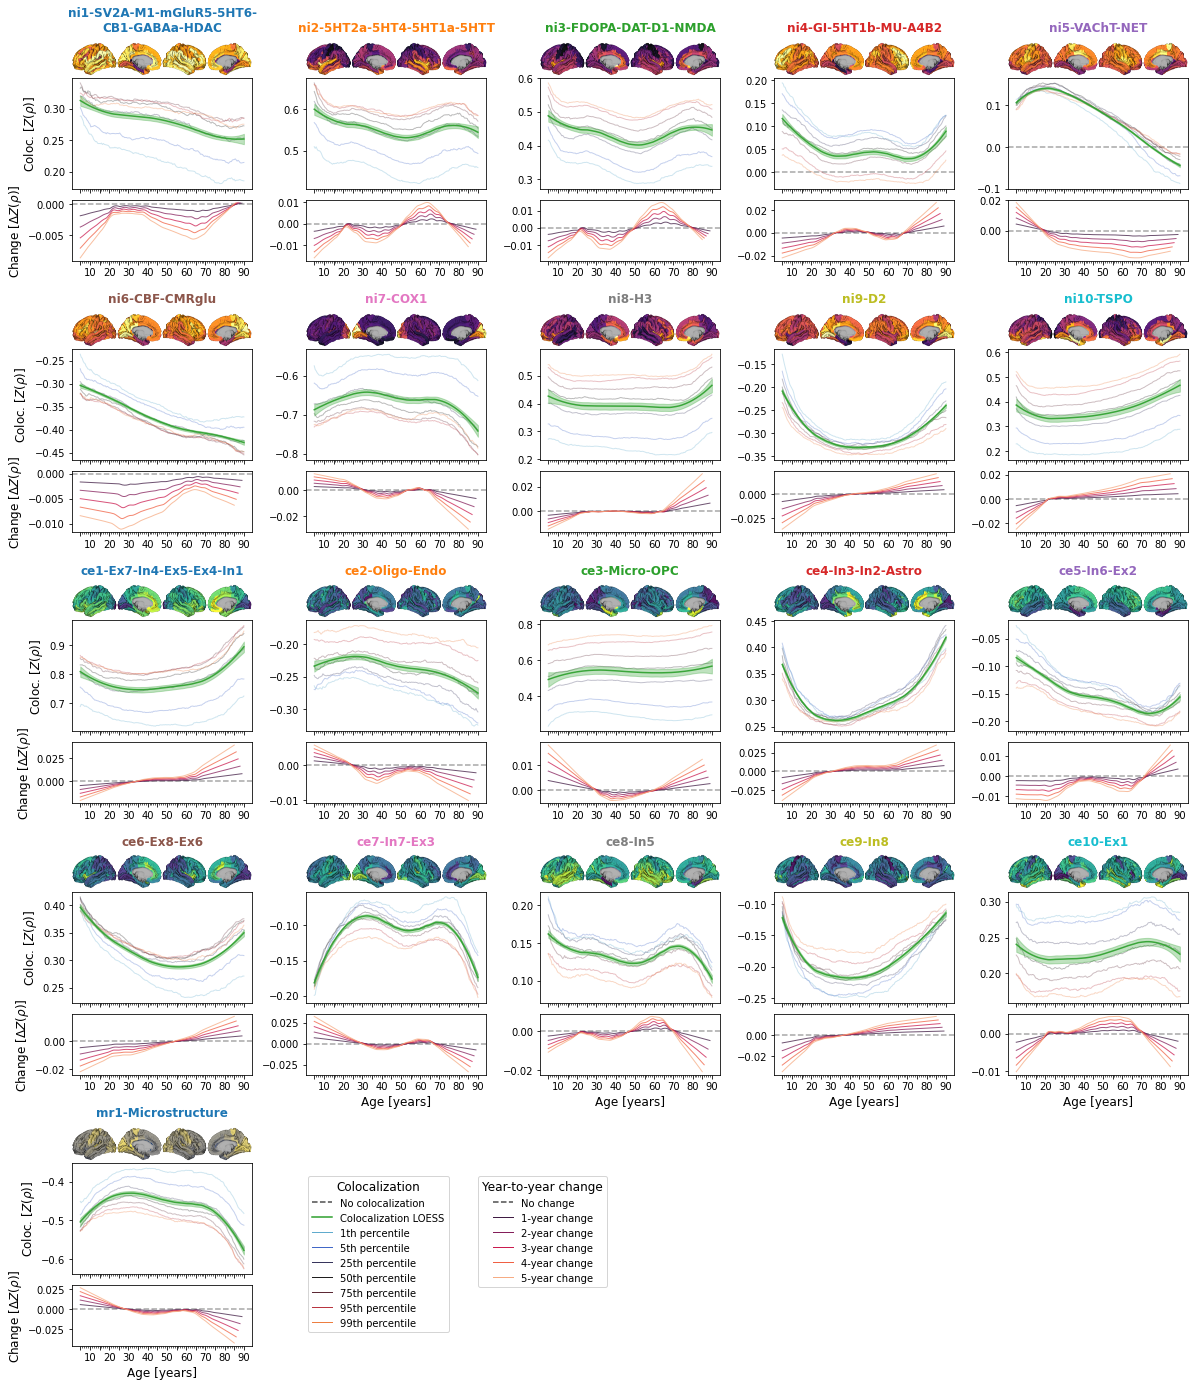

In [50]:
cent_plot = [0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]
tss = [1, 2, 3, 4, 5]
n_cols = 5
n_rows = int(np.ceil(len(predictors)/n_cols))
predictors_tmp = predictors[:4] + [""] + predictors[4:7] + ["mr1-myelin", ""] + predictors[7:-1]
colors = np.r_[get_cmap("tab10")(range(len([p for p in predictors if p.startswith("ni")]))),
               get_cmap("tab10")(range(len([p for p in predictors if p.startswith("ce")]))),
               get_cmap("tab10")(range(1))]
colors_cent = sns.color_palette("icefire", len(cent_plot))
colors_ts = sns.color_palette("rocket", len(tss))

# figure
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4.4*n_rows), 
                         gridspec_kw=dict(hspace=1.45, wspace=0.3))
axes = axes.ravel()

# colocalization data
df = juspyce_spearman["fm"].predictions["spearman"]

# source data
source_data = pd.read_csv(join(plot_dir, f"dev_ct_spearman_fm_source.csv"), index_col=[0,1])

# iterate predictors
for i_pred, pred in enumerate(predictors):
    ax = axes[i_pred]
            
    # title
    ax.set_title(rename_myelin(pred) if len(pred)<30 else pred[:24]+"\n"+pred[24:], 
                 c=colors[i_pred], weight="semibold", size=12, va="bottom")   
    
    # brain
    ax_brain = ax.inset_axes((0, 1, 1, 0.35))
    lh, rh = get_parc_gifti(predictors_destrieux[pred])
    if pred.startswith("ni"): c = "inferno"
    elif pred.startswith("ce"): c = "viridis"
    else: c = "cividis"
    plot_surf_ax(ax=ax_brain, fig=fig, lh=lh, rh=rh, c=c)
  
    # plot CI
    ax.fill_between(
        loess_pred.loc[(slice(None), "loess"), :].index.get_level_values("tp"),
        loess_pred.loc[(slice(None), "ci_up"), pred],
        loess_pred.loc[(slice(None), "ci_low"), pred],
        color="tab:green",
        alpha=0.3,
        zorder=10
    )
    # plot loess line
    ax.plot(
        loess_pred.loc[(slice(None), "loess"), :].index.get_level_values("tp"),
        loess_pred.loc[(slice(None), "loess"), pred],
        c="tab:green",
        alpha=0.9,
        lw=1.5,
        zorder=11,
        label="Colocalization LOESS"
    )
    
    # plot percentile lines
    for i_cent, cent in enumerate(cent_plot):
        ax.plot(
            df.loc[(cent, slice(None)), :].index.get_level_values("tp"),
            df.loc[(cent, slice(None)), pred],
            color=colors_cent[i_cent],
            alpha=0.3,
            lw=1,
            label=f"{int(cent * 100)}th percentile",
            zorder=5
        ) 
        
    # zero line       
    ylims = ax.get_ylim()
    ax.axhline(0, c="0.3", ls="--", alpha=0.5, zorder=-20, label="No colocalization")
    ax.set_ylim(ylims)
        
    # change plot
    ax_change = ax.inset_axes((0, -0.65, 1, 0.55))
    ax_change.axhline(0, c="0.3", ls="--", alpha=0.5, zorder=-8, label="No change")
    for i_ts, ts in enumerate(tss):   
        temp_T0 = loess_pred.loc[(np.arange(5, 89.5, 0.5), "loess"), pred].reset_index(drop=True)
        temp_T1 = loess_pred.loc[(np.arange(5+ts, 90.5, 0.5), "loess"), pred].reset_index(drop=True)
        
        loess_pred_rate = temp_T1 - temp_T0
        loess_pred_rate.index = pd.Index(np.arange(5, 89.5, 0.5))
        
        ax_change.plot(
            loess_pred_rate.index,
            loess_pred_rate,
            alpha=0.75,
            c=colors_ts[i_ts],
            lw=1,
            label=f"{ts}-year change"
        )
        
        # save to source data
        source_data.loc[(pred, loess_pred_rate.index), f"change_{ts}"] = loess_pred_rate.values
        
    # x axis
    ax.set_xticks(np.arange(5,91,5))
    ax.set_xticks(np.arange(5,91,1), minor=True)
    ax.set_xticklabels([])
    ax_change.set_xlim(ax.get_xlim())
    ax_change.set_xticks(np.arange(5,91,5))
    ax_change.set_xticks(np.arange(5,91,1), minor=True)
    ax_change.set_xticklabels(sum([["",i] for i in np.arange(10,91,10)], []))
    
    # labels
    if i_pred in range(16, 21):
        ax_change.set_xlabel("Age [years]", size=12)
    if i_pred in [i * n_cols for i in range(n_rows)]:
        ax.set_ylabel("Coloc. "+r"[$Z (\rho)$]", size=12)
        ax_change.set_ylabel("Change "+r"[$\Delta Z (\rho)$]", size=12)
       
# empty plots   
hide_empty_axes(axes)
        
# legend coloc
handles, labels = ax.get_legend_handles_labels()
handles, labels = handles[-1:] + handles[:-1], labels[-1:] + labels[:-1]
leg = fig.legend(handles=handles, labels=labels, loc='upper right', 
                 ncol=1, bbox_to_anchor=(0.39, 0.19), title="Colocalization", title_fontsize=12) 
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    
# legend change
handles, labels = ax_change.get_legend_handles_labels()
leg = fig.legend(handles=handles, labels=labels, loc='upper right', 
                 ncol=1, bbox_to_anchor=(0.5, 0.19), title="Year-to-year change", title_fontsize=12) 
for lh in leg.legendHandles: 
    lh.set_alpha(1)

# save
fig.savefig(join(plot_dir, f"dev_ct_spearman_fm_combined.pdf"), bbox_inches="tight", dpi=400)

# save source
source_data.to_csv(join(plot_dir, f"dev_ct_spearman_fm_combined_source.csv"))